In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(10)

# Set the Seaborn style and context
sns.set(style="darkgrid", context="talk", palette="muted")

# Simulating Stochastic Differential Equations

In [47]:
def gbm(r, vol, S0, T, ntimes, nsims):
    """
    Simulate multiple paths of Geometric Brownian Motion (GBM) using the Euler-Maruyama method.
    
    Parameters:
    - r (float): Drift coefficient.
    - vol (float): Volatility coefficient.
    - S0 (float): Initial stock price.
    - T (float): Total time in years.
    - ntimes (int): Number of time steps.
    - nsims (int): Number of simulations.
    
    Returns:
    - t (numpy array): Array of time points.
    - S (numpy array): Array of simulated stock price paths.
    """
    dt = T / ntimes  # Time step size
    t = np.linspace(0, T, ntimes)
    S = np.zeros((ntimes, nsims))
    S[0, :] = S0

    for i in range(1, ntimes):
        dZ = np.random.normal(0, np.sqrt(dt), nsims)
        S[i, :] = S[i-1, :] * (1 + r * dt + vol * dZ)
    return S


def cev(r, vol, gamma, S0, T, ntimes, nsims):
    """
    Simulate multiple paths of the Constant Elasticity of Variance (CEV) model 
    using the Euler-Maruyama method.
    
    Parameters:
    - r (float): Risk-free rate.
    - vol (float): Volatility coefficient.
    - gamma (float): Elasticity parameter.
    - S0 (float): Initial stock price.
    - T (float): Total time in years.
    - ntimes (int): Number of time steps.
    - nsims (int): Number of simulations.
    
    Returns:
    - S (numpy array): Array of simulated stock price paths across the specified time period.
    """
    dt = T / ntimes  # Time step size
    S = np.zeros((ntimes, nsims))
    S[0, :] = S0

    for i in range(1, ntimes):
        dZ = np.random.normal(0, np.sqrt(dt), nsims)
        S[i, :] = S[i-1, :] + r * S[i-1, :] * dt + vol * (S[i-1, :]**gamma) * dZ
    
    return S


def mjd(r, vol, mu_J, vol_J, lambda_, S0, T, ntimes, nsims):
    """
    Simulate multiple paths of the Merton Jump-Diffusion (MJD) model 
    using the Euler-Maruyama method with jumps.
    
    Parameters:
    - r (float): Risk-free rate.
    - vol (float): Volatility coefficient.
    - mu_J (float): Mean of the jump size in logarithmic terms.
    - vol_J (float): Standard deviation of the jump size in logarithmic terms.
    - lambda_ (float): Jump intensity (average number of jumps per unit time).
    - S0 (float): Initial stock price.
    - T (float): Total time in years.
    - ntimes (int): Number of time steps.
    - nsims (int): Number of simulations.
    
    Returns:
    - S (numpy array): Array of simulated stock price paths.
    """
    dt = T / ntimes  # Time step size
    S = np.zeros((ntimes, nsims))
    S[0, :] = S0
    jump_lambda_dt = lambda_ * dt

    for i in range(1, ntimes):
        dZ = np.random.normal(0, np.sqrt(dt), nsims)  # Normal increments for GBM
        Nt = np.random.poisson(jump_lambda_dt, nsims)  # Poisson increments for jumps
        Y = np.random.normal(mu_J, vol_J, nsims * np.max(Nt)).reshape(nsims, -1)
        jumps = np.sum(np.exp(Y) - 1, axis=1) * (Nt > 0)  # Apply jumps only where Nt > 0

        S[i, :] = S[i-1, :] * (1 + r * dt + vol * dZ + jumps)

    return S


def heston(r, kappa, theta, sigma, rho, S0, v0, T, ntimes, nsims):
    """
    Simulate multiple paths of the Heston model using the Euler-Maruyama method.
    
    Parameters:
    - r (float): Risk-free rate.
    - kappa (float): Rate of mean reversion.
    - theta (float): Long-term variance.
    - sigma (float): Volatility of volatility.
    - rho (float): Correlation between the two Brownian motions.
    - S0 (float): Initial stock price.
    - v0 (float): Initial variance.
    - T (float): Total time in years.
    - ntimes (int): Number of time steps.
    - nsims (int): Number of simulations.
    
    Returns:
    - S (numpy array): Simulated stock price paths.
    - V (numpy array): Simulated variance paths.
    """
    dt = T / ntimes  # Time step size
    S = np.zeros((ntimes, nsims))
    V = np.zeros((ntimes, nsims))
    S[0, :] = S0
    V[0, :] = v0

    # Cholesky decomposition to generate correlated Brownian motions
    chol = np.array([[1, 0], [rho, np.sqrt(1 - rho**2)]])

    for i in range(1, ntimes):
        dZ = np.random.normal(0, np.sqrt(dt), (2, nsims))
        dZ = chol @ dZ  # Generate two correlated Brownian motion increments
        dZ1 = dZ[0, :]
        dZ2 = dZ[1, :]
        
        # Ensure variance stays positive
        V[i, :] = np.maximum(V[i-1, :] + kappa * (theta - V[i-1, :]) * dt + sigma * np.sqrt(np.maximum(V[i-1, :], 0)) * dZ2, 0)
        S[i, :] = S[i-1, :] * (1 + r * dt + np.sqrt(np.maximum(V[i-1, :], 0)) * dZ1)

    return S


def bates(r, kappa, theta, sigma, rho, lambda_Js, mu_Js, sigma_Js, lambda_Jv, mu_Jv, sigma_Jv, S0, v0, T, ntimes, nsims):
    """
    Simulate multiple paths of the Bates model using the Euler-Maruyama method with jumps in stock price and variance.
    
    Parameters:
    - r (float): Risk-free rate.
    - kappa (float): Rate of mean reversion of variance.
    - theta (float): Long-term variance.
    - sigma (float): Volatility of volatility.
    - rho (float): Correlation between stock and variance Brownian motions.
    - lambda_Js (float): Intensity of jumps in stock price.
    - mu_Js (float): Mean of logarithm of stock price jumps.
    - sigma_Js (float): Volatility of logarithm of stock price jumps.
    - lambda_Jv (float): Intensity of jumps in variance.
    - mu_Jv (float): Mean of logarithm of variance jumps.
    - sigma_Jv (float): Volatility of logarithm of variance jumps.
    - S0 (float): Initial stock price.
    - v0 (float): Initial variance.
    - T (float): Total time in years.
    - ntimes (int): Number of time steps.
    - nsims (int): Number of simulations.
    
    Returns:
    - S (numpy array): Simulated stock price paths.
    - V (numpy array): Simulated variance paths.
    """
    dt = T / ntimes
    S = np.zeros((ntimes, nsims))
    V = np.zeros((ntimes, nsims))
    S[0, :] = S0
    V[0, :] = v0

    # Cholesky decomposition for correlated Brownian motions
    chol = np.array([[1, 0], [rho, np.sqrt(1 - rho**2)]])
    
    for i in range(1, ntimes):
        dZ = np.random.normal(0, np.sqrt(dt), (2, nsims))
        dZ = chol @ dZ
        dZ1 = dZ[0, :]
        dZ2 = dZ[1, :]

        # Jump calculations for stock price
        Ns = np.random.poisson(lambda_Js * dt, nsims)
        Js = np.sum(np.random.normal(mu_Js, sigma_Js, (nsims, max(Ns))) * (Ns[:, None] > np.arange(max(Ns))), axis=1)

        # Jump calculations for variance
        Nv = np.random.poisson(lambda_Jv * dt, nsims)
        Jv = np.sum(np.random.normal(mu_Jv, sigma_Jv, (nsims, max(Nv))) * (Nv[:, None] > np.arange(max(Nv))), axis=1)

        # Update variance and stock paths
        V[i, :] = np.maximum(V[i-1, :] + kappa * (theta - V[i-1, :]) * dt + sigma * np.sqrt(np.maximum(V[i-1, :], 0)) * dZ2 + Jv, 0)
        S[i, :] = S[i-1, :] * np.exp((r - 0.5 * np.maximum(V[i-1, :], 0)) * dt + np.sqrt(np.maximum(V[i-1, :], 0)) * dZ1 + Js)

    return S

# Pricing Exotic Options

In [48]:
def european_option_price(S, X, r, T, option_type):
    """
    Price a European call or put option using simulated stock prices.

    Parameters:
    - S (numpy array): Matrix of simulated stock price paths.
    - X (float): Strike price of the option.
    - r (float): Risk-free interest rate.
    - T (float): Maturity of the option in years.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: The estimated price of the European option.
    """
    if option_type == 'call':
        payoff = np.maximum(S[-1, :] - X, 0)
    elif option_type == 'put':
        payoff = np.maximum(X - S[-1, :], 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    discounted_payoff = np.exp(-r * T) * np.mean(payoff)
    return discounted_payoff


def asian_option_price(S, X, r, T, option_type):
    """
    Price an Asian call or put option using simulated stock prices, a given strike price, and option type.

    Parameters:
    - S (numpy array): Matrix of simulated stock price paths.
    - X (float): Strike price of the option.
    - r (float): Risk-free interest rate.
    - T (float): Maturity of the option in years.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: The estimated price of the Asian option.
    """
    average_prices = np.mean(S, axis=0)

    if option_type == 'call':
        payoff = np.maximum(average_prices - X, 0)
    elif option_type == 'put':
        payoff = np.maximum(X - average_prices, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    discounted_payoff = np.exp(-r * T) * np.mean(payoff)
    return discounted_payoff


def lookback_option_price(S, r, T, option_type):
    """
    Price a lookback call or put option using simulated stock prices.

    Parameters:
    - S (numpy array): Matrix of simulated stock price paths.
    - r (float): Risk-free interest rate.
    - T (float): Maturity of the option in years.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: The estimated price of the lookback option.
    """
    if option_type == 'call':
        payoff = np.maximum(S[-1, :] - np.min(S, axis=0), 0)
    elif option_type == 'put':
        payoff = np.maximum(np.max(S, axis=0) - S[-1, :], 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
        
    discounted_payoff = np.exp(-r * T) * np.mean(payoff)
    return discounted_payoff


def exchange_option_price(S, A, r, T, option_type):
    """
    Price an exchange call or put option using simulated price paths for two assets.

    Parameters:
    - S (numpy array): Matrix of simulated stock price paths for stock S.
    - A (numpy array): Matrix of simulated stock price paths for stock A (the strike stock).
    - r (float): Risk-free interest rate.
    - T (float): Maturity of the option in years.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: The estimated price of the exchange option.
    """
    if option_type == 'call':
        payoff = np.maximum(S[-1, :] - A[-1, :], 0)
    elif option_type == 'put':
        payoff = np.maximum(A[-1, :] - S[-1, :], 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    discounted_payoff = np.exp(-r * T) * np.mean(payoff)
    return discounted_payoff


def max_asset_option_price(S, A, r, T):
    """
    Price a maximum asset option using simulated price paths for two assets.

    Parameters:
    - S (numpy array): Matrix of simulated stock price paths for stock S.
    - A (numpy array): Matrix of simulated stock price paths for stock A.
    - r (float): Risk-free interest rate.
    - T (float): Maturity of the option in years.

    Returns:
    - float: The estimated price of the maximum asset option.
    """
    max_values = np.maximum(S[-1, :], A[-1, :])

    discounted_payoff = np.exp(-r * T) * np.mean(max_values)
    return discounted_payoff

def min_asset_option_price(S, A, r, T):
    """
    Price a minimum asset option using simulated price paths for two assets.

    Parameters:
    - S (numpy array): Matrix of simulated stock price paths for stock S.
    - A (numpy array): Matrix of simulated stock price paths for stock A.
    - r (float): Risk-free interest rate.
    - T (float): Maturity of the option in years.

    Returns:
    - float: The estimated price of the minimum asset option.
    """
    min_values = np.minimum(S[-1, :], A[-1, :])

    discounted_payoff = np.exp(-r * T) * np.mean(min_values)
    return discounted_payoff

# Numerical Examples

## Parameters

In [49]:
# Define common parameters
S0 = 10      # Initial stock price
A0 = 15      # Initial stock price
X = 12      # Strike price
r = 0.08     # Risk-free rate
vol = 0.3    # Volatility
T = 2        # Maturity in years
ntimes = 100 # Number of time steps
nsims = 20000 # Number of simulations

# GBM Simulation
S_gbm = gbm(r, vol, S0, T, ntimes, nsims)
A_gbm = gbm(r, vol, A0, T, ntimes, nsims)

# CEV Simulation
gamma = 0.75  # Specific to CEV model
S_cev = cev(r, vol, gamma, S0, T, ntimes, nsims)

# MJD Simulation
mu_J = -0.2    # Mean of the jump size
vol_J = 0.1    # Volatility of the jump size
lambda_ = 1.0  # Jump intensity
S_mjd = mjd(r, vol, mu_J, vol_J, lambda_, S0, T, ntimes, nsims)

# Heston Simulation
kappa = 1.5   # Rate of mean reversion
theta = 0.04  # Long-term variance
sigma_v = 0.3 # Volatility of volatility
rho = -0.7    # Correlation between the two Brownian motions
v0 = 0.04     # Initial variance
S_heston = heston(r, kappa, theta, sigma_v, rho, S0, v0, T, ntimes, nsims)

# Bates Simulation
lambda_Js = 1.0  # Intensity of jumps in stock price
mu_Js = -0.2     # Mean of logarithm of stock price jumps
sigma_Js = 0.1   # Volatility of stock jump size
lambda_Jv = 1.0  # Intensity of jumps in variance
mu_Jv = -0.2     # Mean of variance jumps
sigma_Jv = 0.1   # Volatility of variance jumps
S_bates = bates(r, kappa, theta, sigma_v, rho, lambda_Js, mu_Js, sigma_Js, lambda_Jv, mu_Jv, sigma_Jv, S0, v0, T, ntimes, nsims)

## Plots of the asset paths using the SDEs

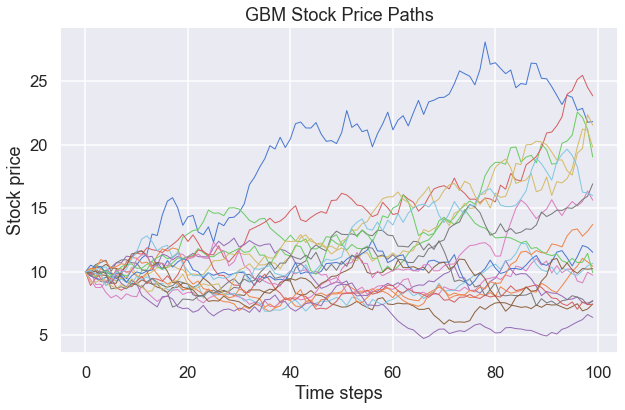

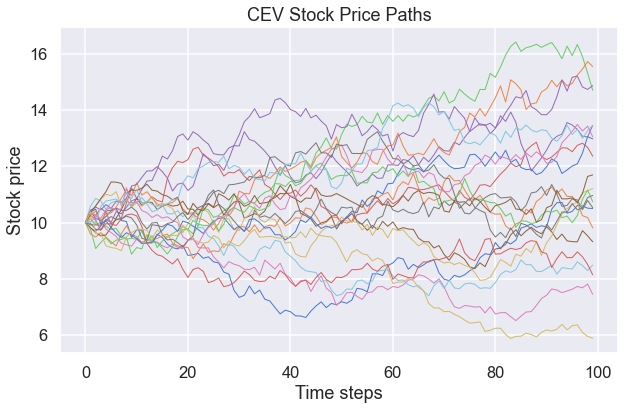

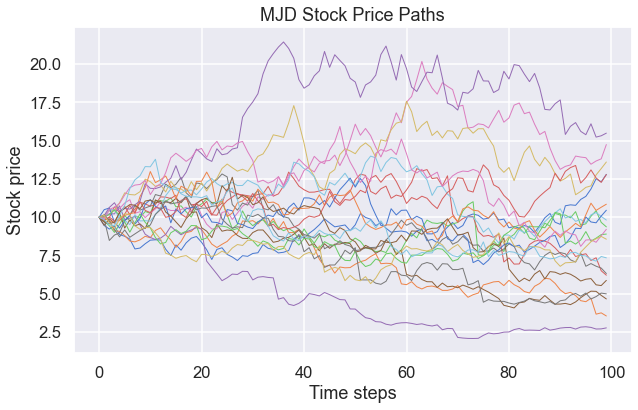

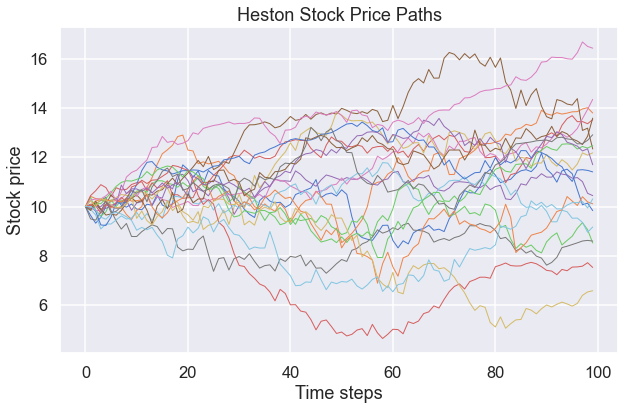

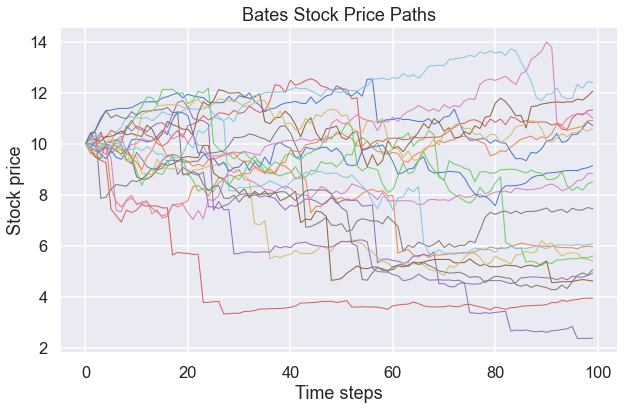

In [50]:
ntimes_plot = 100 # Number of time steps
nsims_plot = 20   # Number of simulations set to 20 for plotting

# Simulations with updated nsims for plotting for each model
S_gbm_plot = gbm(r, vol, S0, T, ntimes_plot, nsims_plot)
S_cev_plot = cev(r, vol, gamma, S0, T, ntimes_plot, nsims_plot)
S_mjd_plot = mjd(r, vol, mu_J, vol_J, lambda_, S0, T, ntimes_plot, nsims_plot)
S_heston_plot = heston(r, kappa, theta, sigma_v, rho, S0, v0, T, ntimes_plot, nsims_plot)
S_bates_plot = bates(r, kappa, theta, sigma_v, rho, lambda_Js, mu_Js, sigma_Js, lambda_Jv, mu_Jv, sigma_Jv, S0, v0, T, ntimes_plot, nsims_plot)

def plot_and_save_sde_paths(S, model_name):
    plt.figure(figsize=(10, 6))
    for i in range(S.shape[1]):
        plt.plot(S[:, i], linewidth=1)
    plt.title(f'{model_name} Stock Price Paths')
    plt.xlabel('Time steps')
    plt.ylabel('Stock price')
    plt.grid(True)
    
    # Save the figure
    plt.savefig(f"{model_name}_Stock_Price_Paths.png", dpi=300)
    plt.show()

# Plotting and saving the asset paths for each model
plot_and_save_sde_paths(S_gbm_plot, 'GBM')
plot_and_save_sde_paths(S_cev_plot, 'CEV')
plot_and_save_sde_paths(S_mjd_plot, 'MJD')
plot_and_save_sde_paths(S_heston_plot, 'Heston')
plot_and_save_sde_paths(S_bates_plot, 'Bates')

## Pricing the options

#### Pricing Vanilla European Option

In [51]:
option_type_call = 'call'
option_type_put = 'put'

european_call_price_gbm = european_option_price(S_gbm, X, r, T, option_type_call)
european_put_price_gbm = european_option_price(S_gbm, X, r, T, option_type_put)

european_call_price_cev = european_option_price(S_cev, X, r, T, option_type_call)
european_put_price_cev = european_option_price(S_cev, X, r, T, option_type_put)

european_call_price_mjd = european_option_price(S_mjd, X, r, T, option_type_call)
european_put_price_mjd = european_option_price(S_mjd, X, r, T, option_type_put)

european_call_price_heston = european_option_price(S_heston, X, r, T, option_type_call)
european_put_price_heston = european_option_price(S_heston, X, r, T, option_type_put)

european_call_price_bates = european_option_price(S_bates, X, r, T, option_type_call)
european_put_price_bates = european_option_price(S_bates, X, r, T, option_type_put)

print("European Option Prices:")
print("---------------------------------------------------")
print(f"{'SDE':<10} | {'Call Price':<15} | {'Put Price':<15}")
print("---------------------------------------------------")
print(f"{'GBM':<10} | {european_call_price_gbm:<15.4f} | {european_put_price_gbm:<15.4f}")
print(f"{'CEV':<10} | {european_call_price_cev:<15.4f} | {european_put_price_cev:<15.4f}")
print(f"{'MJD':<10} | {european_call_price_mjd:<15.4f} | {european_put_price_mjd:<15.4f}")
print(f"{'Heston':<10} | {european_call_price_heston:<15.4f} | {european_put_price_heston:<15.4f}")
print(f"{'Bates':<10} | {european_call_price_bates:<15.4f} | {european_put_price_bates:<15.4f}")
print("---------------------------------------------------")

European Option Prices:
---------------------------------------------------
SDE        | Call Price      | Put Price      
---------------------------------------------------
GBM        | 1.5377          | 1.8345         
CEV        | 0.8361          | 1.0501         
MJD        | 0.3366          | 5.5312         
Heston     | 0.9293          | 1.1812         
Bates      | 0.1660          | 3.3701         
---------------------------------------------------


#### Pricing Asian Option

In [52]:
asian_call_price_gbm = asian_option_price(S_gbm, X, r, T, option_type_call)
asian_put_price_gbm = asian_option_price(S_gbm, X, r, T, option_type_put)

asian_call_price_cev = asian_option_price(S_cev, X, r, T, option_type_call)
asian_put_price_cev = asian_option_price(S_cev, X, r, T, option_type_put)

asian_call_price_mjd = asian_option_price(S_mjd, X, r, T, option_type_call)
asian_put_price_mjd = asian_option_price(S_mjd, X, r, T, option_type_put)

asian_call_price_heston = asian_option_price(S_heston, X, r, T, option_type_call)
asian_put_price_heston = asian_option_price(S_heston, X, r, T, option_type_put)

asian_call_price_bates = asian_option_price(S_bates, X, r, T, option_type_call)
asian_put_price_bates = asian_option_price(S_bates, X, r, T, option_type_put)

print("Asian Option Prices:")
print("---------------------------------------------------")
print(f"{'SDE':<10} | {'Call Price':<15} | {'Put Price':<15}")
print("---------------------------------------------------")
print(f"{'GBM':<10} | {asian_call_price_gbm:<15.4f} | {asian_put_price_gbm:<15.4f}")
print(f"{'CEV':<10} | {asian_call_price_cev:<15.4f} | {asian_put_price_cev:<15.4f}")
print(f"{'MJD':<10} | {asian_call_price_mjd:<15.4f} | {asian_put_price_mjd:<15.4f}")
print(f"{'Heston':<10} | {asian_call_price_heston:<15.4f} | {asian_put_price_heston:<15.4f}")
print(f"{'Bates':<10} | {asian_call_price_bates:<15.4f} | {asian_put_price_bates:<15.4f}")
print("---------------------------------------------------")

Asian Option Prices:
---------------------------------------------------
SDE        | Call Price      | Put Price      
---------------------------------------------------
GBM        | 0.5439          | 1.5499         
CEV        | 0.1763          | 1.1647         
MJD        | 0.1500          | 3.7417         
Heston     | 0.1993          | 1.1873         
Bates      | 0.0389          | 2.5138         
---------------------------------------------------


#### Pricing Lookback Option

In [53]:
lookback_call_price_gbm = lookback_option_price(S_gbm, r, T, option_type_call)
lookback_put_price_gbm = lookback_option_price(S_gbm, r, T, option_type_put)

lookback_call_price_cev = lookback_option_price(S_cev, r, T, option_type_call)
lookback_put_price_cev = lookback_option_price(S_cev, r, T, option_type_put)

lookback_call_price_mjd = lookback_option_price(S_mjd, r, T, option_type_call)
lookback_put_price_mjd = lookback_option_price(S_mjd, r, T, option_type_put)

lookback_call_price_heston = lookback_option_price(S_heston, r, T, option_type_call)
lookback_put_price_heston = lookback_option_price(S_heston, r, T, option_type_put)

lookback_call_price_bates = lookback_option_price(S_bates, r, T, option_type_call)
lookback_put_price_bates = lookback_option_price(S_bates, r, T, option_type_put)

print("Lookback Option Prices:")
print("---------------------------------------------------")
print(f"{'SDE':<10} | {'Call Price':<15} | {'Put Price':<15}")
print("---------------------------------------------------")
print(f"{'GBM':<10} | {lookback_call_price_gbm:<15.4f} | {lookback_put_price_gbm:<15.4f}")
print(f"{'CEV':<10} | {lookback_call_price_cev:<15.4f} | {lookback_put_price_cev:<15.4f}")
print(f"{'MJD':<10} | {lookback_call_price_mjd:<15.4f} | {lookback_put_price_mjd:<15.4f}")
print(f"{'Heston':<10} | {lookback_call_price_heston:<15.4f} | {lookback_put_price_heston:<15.4f}")
print(f"{'Bates':<10} | {lookback_call_price_bates:<15.4f} | {lookback_put_price_bates:<15.4f}")
print("---------------------------------------------------")

Lookback Option Prices:
---------------------------------------------------
SDE        | Call Price      | Put Price      
---------------------------------------------------
GBM        | 3.3264          | 2.5928         
CEV        | 2.4144          | 1.0597         
MJD        | 1.2562          | 5.7409         
Heston     | 2.7221          | 1.2129         
Bates      | 1.1316          | 2.8548         
---------------------------------------------------


#### Pricing Exchange Option

In [54]:
A_cev = cev(r, vol, gamma, A0, T, ntimes, nsims)
A_mjd = mjd(r, vol, mu_J, vol_J, lambda_, A0, T, ntimes, nsims)
A_heston = heston(r, kappa, theta, sigma_v, rho, A0, v0, T, ntimes, nsims)
A_bates = bates(r, kappa, theta, sigma_v, rho, lambda_Js, mu_Js, sigma_Js, lambda_Jv, mu_Jv, sigma_Jv, A0, v0, T, ntimes, nsims)

exchange_call_price_gbm = exchange_option_price(S_gbm, A_gbm, r, T, option_type_call)
exchange_put_price_gbm = exchange_option_price(S_gbm, A_gbm, r, T, option_type_put)

exchange_call_price_cev = exchange_option_price(S_cev, A_cev, r, T, option_type_call)
exchange_put_price_cev = exchange_option_price(S_cev, A_cev, r, T, option_type_put)

exchange_call_price_mjd = exchange_option_price(S_mjd, A_mjd, r, T, option_type_call)
exchange_put_price_mjd = exchange_option_price(S_mjd, A_mjd, r, T, option_type_put)

exchange_call_price_heston = exchange_option_price(S_heston, A_heston, r, T, option_type_call)
exchange_put_price_heston = exchange_option_price(S_heston, A_heston, r, T, option_type_put)

exchange_call_price_bates = exchange_option_price(S_bates, A_bates, r, T, option_type_call)
exchange_put_price_bates = exchange_option_price(S_bates, A_bates, r, T, option_type_put)

print("Exchange Option Prices:")
print("---------------------------------------------------")
print(f"{'SDE':<10} | {'Call Price':<15} | {'Put Price':<15}")
print("---------------------------------------------------")
print(f"{'GBM':<10} | {exchange_call_price_gbm:<15.4f} | {exchange_put_price_gbm:<15.4f}")
print(f"{'CEV':<10} | {exchange_call_price_cev:<15.4f} | {exchange_put_price_cev:<15.4f}")
print(f"{'MJD':<10} | {exchange_call_price_mjd:<15.4f} | {exchange_put_price_mjd:<15.4f}")
print(f"{'Heston':<10} | {exchange_call_price_heston:<15.4f} | {exchange_put_price_heston:<15.4f}")
print(f"{'Bates':<10} | {exchange_call_price_bates:<15.4f} | {exchange_put_price_bates:<15.4f}")
print("---------------------------------------------------")

Exchange Option Prices:
---------------------------------------------------
SDE        | Call Price      | Put Price      
---------------------------------------------------
GBM        | 1.0262          | 6.1073         
CEV        | 0.1764          | 5.1642         
MJD        | 1.4112          | 3.7821         
Heston     | 0.3676          | 5.3655         
Bates      | 0.5628          | 4.0773         
---------------------------------------------------


#### Pricing Maximum Asset Option

In [55]:
max_asset_price_gbm = max_asset_option_price(S_gbm, A_gbm, r, T)
max_asset_price_cev = max_asset_option_price(S_cev, A_cev, r, T)
max_asset_price_mjd = max_asset_option_price(S_mjd, A_mjd, r, T)
max_asset_price_heston = max_asset_option_price(S_heston, A_heston, r, T)
max_asset_price_bates = max_asset_option_price(S_bates, A_bates, r, T)

print("Maximum Asset Option Prices:")
print("---------------------------------------------------")
print(f"{'SDE':<10} | {'Max Asset Price':<20}")
print("---------------------------------------------------")
print(f"{'GBM':<10} | {max_asset_price_gbm:<20.4f}")
print(f"{'CEV':<10} | {max_asset_price_cev:<20.4f}")
print(f"{'MJD':<10} | {max_asset_price_mjd:<20.4f}")
print(f"{'Heston':<10} | {max_asset_price_heston:<20.4f}")
print(f"{'Bates':<10} | {max_asset_price_bates:<20.4f}")
print("---------------------------------------------------")

Maximum Asset Option Prices:
---------------------------------------------------
SDE        | Max Asset Price     
---------------------------------------------------
GBM        | 16.0362             
CEV        | 15.1760             
MJD        | 8.8132              
Heston     | 15.3393             
Bates      | 11.0990             
---------------------------------------------------


#### Pricing Minimum Asset Option

In [56]:
min_asset_price_gbm = min_asset_option_price(S_gbm, A_gbm, r, T)
min_asset_price_cev = min_asset_option_price(S_cev, A_cev, r, T)
min_asset_price_mjd = min_asset_option_price(S_mjd, A_mjd, r, T)
min_asset_price_heston = min_asset_option_price(S_heston, A_heston, r, T)
min_asset_price_bates = min_asset_option_price(S_bates, A_bates, r, T)

print("Minimum Asset Option Prices:")
print("---------------------------------------------------")
print(f"{'SDE':<10} | {'Min Asset Price':<20}")
print("---------------------------------------------------")
print(f"{'GBM':<10} | {min_asset_price_gbm:<20.4f}")
print(f"{'CEV':<10} | {min_asset_price_cev:<20.4f}")
print(f"{'MJD':<10} | {min_asset_price_mjd:<20.4f}")
print(f"{'Heston':<10} | {min_asset_price_heston:<20.4f}")
print(f"{'Bates':<10} | {min_asset_price_bates:<20.4f}")
print("---------------------------------------------------")

Minimum Asset Option Prices:
---------------------------------------------------
SDE        | Min Asset Price     
---------------------------------------------------
GBM        | 8.9027              
CEV        | 9.8354              
MJD        | 3.6199              
Heston     | 9.6062              
Bates      | 6.4589              
---------------------------------------------------
